In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
torch.cuda.is_available()
torch.cuda.get_device_name(0)

cuda:0


'NVIDIA GeForce RTX 2060 SUPER'

In [38]:
BASE_PATH = 'C:/Users/Manel/Desktop/Practica2/git/CustomViT/Plants_ds/'
data = pd.read_csv("C:/Users/Manel/Desktop/Practica2/git/CustomViT/Plants_ds/data.csv")

batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
# from sklearn.model_selection import train_test_split
# tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [39]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [40]:
class Plants_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [41]:
dataset = Plants_Dataset(data,BASE_PATH,transform)

In [42]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [43]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

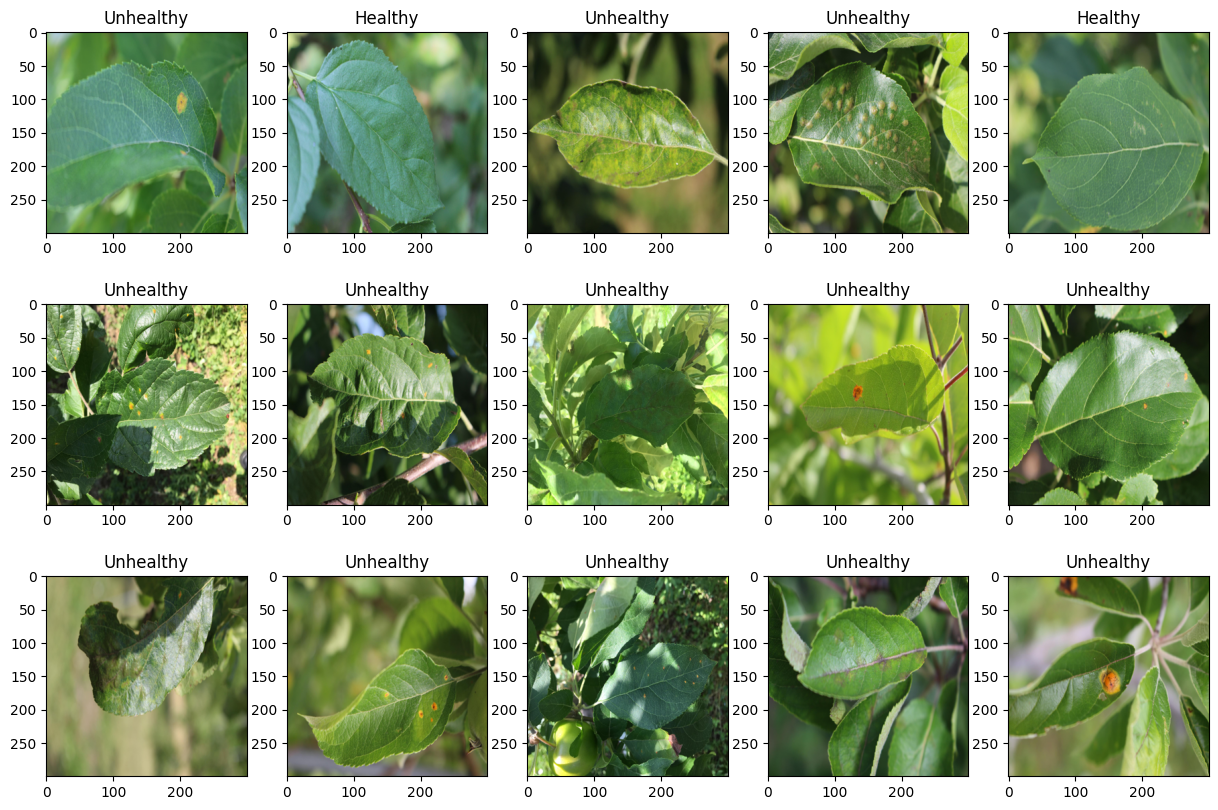

In [44]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Healthy', 1: 'Unhealthy'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [46]:
#modelo: Classifying Cursive hiragana KMNIST using CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [47]:
#model = Net() # On CPU
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [74]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [75]:
#Train
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/12], Step [0/10], Loss: 1.0209

train loss: 1.0524, train acc: 55.6863
validation loss: 0.8619, validation acc: 70.8791

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/10], Loss: 0.9633

train loss: 1.0340, train acc: 57.0980
validation loss: 0.8657, validation acc: 69.0476

Epoch 3

Epoch [3/12], Step [0/10], Loss: 0.9838

train loss: 1.0397, train acc: 54.9020
validation loss: 0.8592, validation acc: 69.4139

Detected network improvement, saving current model
Epoch 4

Epoch [4/12], Step [0/10], Loss: 0.9872

train loss: 1.0346, train acc: 57.4118
validation loss: 0.8637, validation acc: 70.3297

Epoch 5

Epoch [5/12], Step [0/10], Loss: 1.0783

train loss: 1.0354, train acc: 56.7843
validation loss: 0.8639, validation acc: 71.9780

Epoch 6

Epoch [6/12], Step [0/10], Loss: 1.0281

train loss: 1.0301, train acc: 56.5490
validation loss: 0.8570, validation acc: 70.1465

Detected network improvement, saving current model
Epoch 7

Epoc

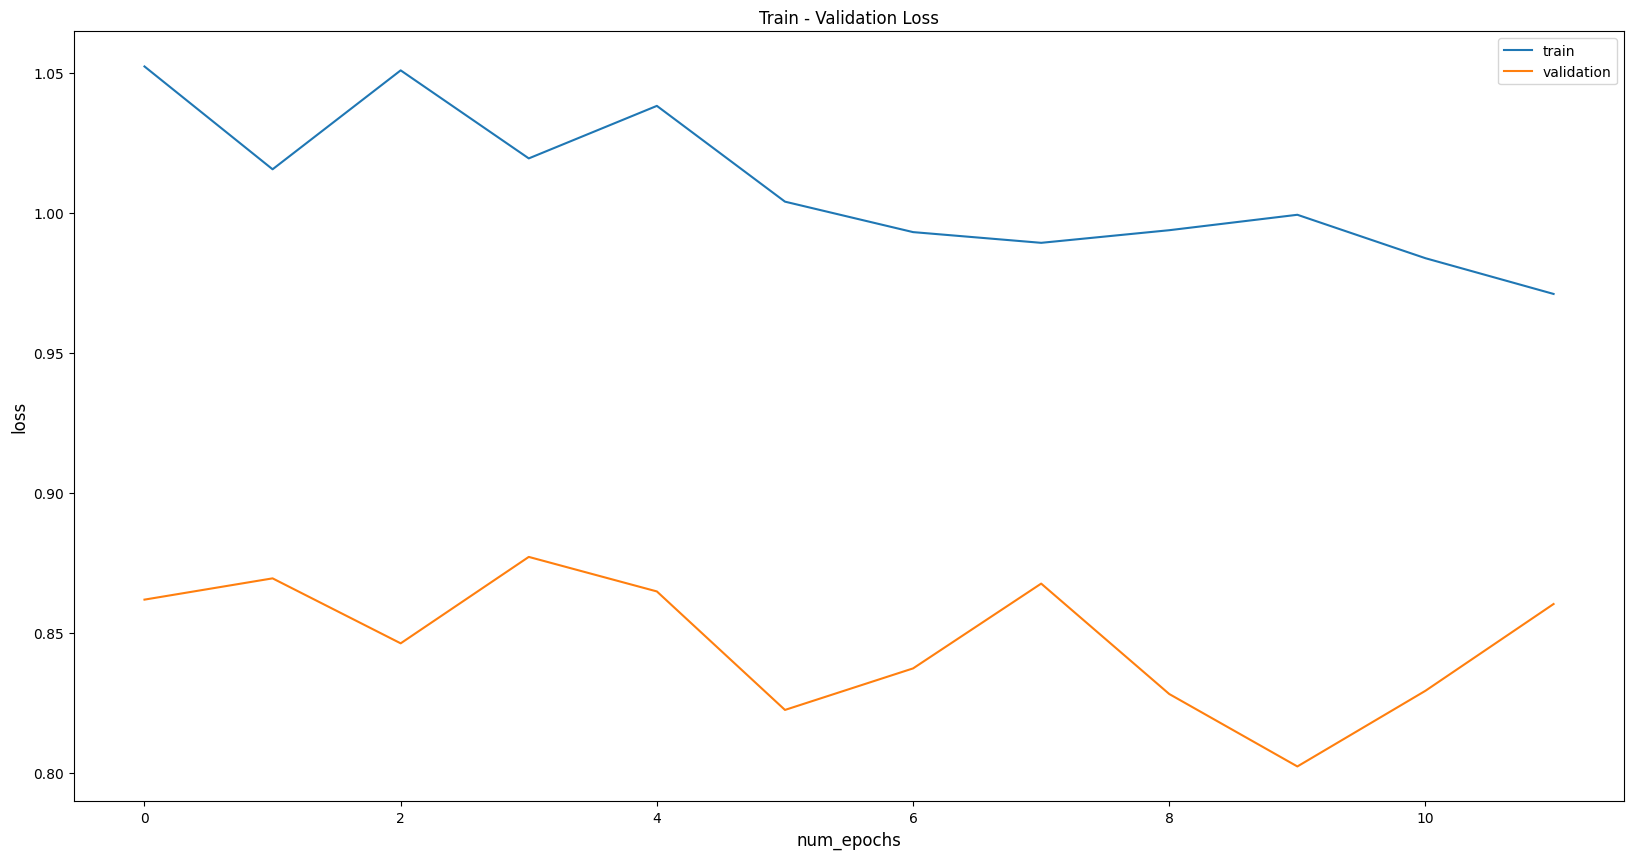

In [76]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

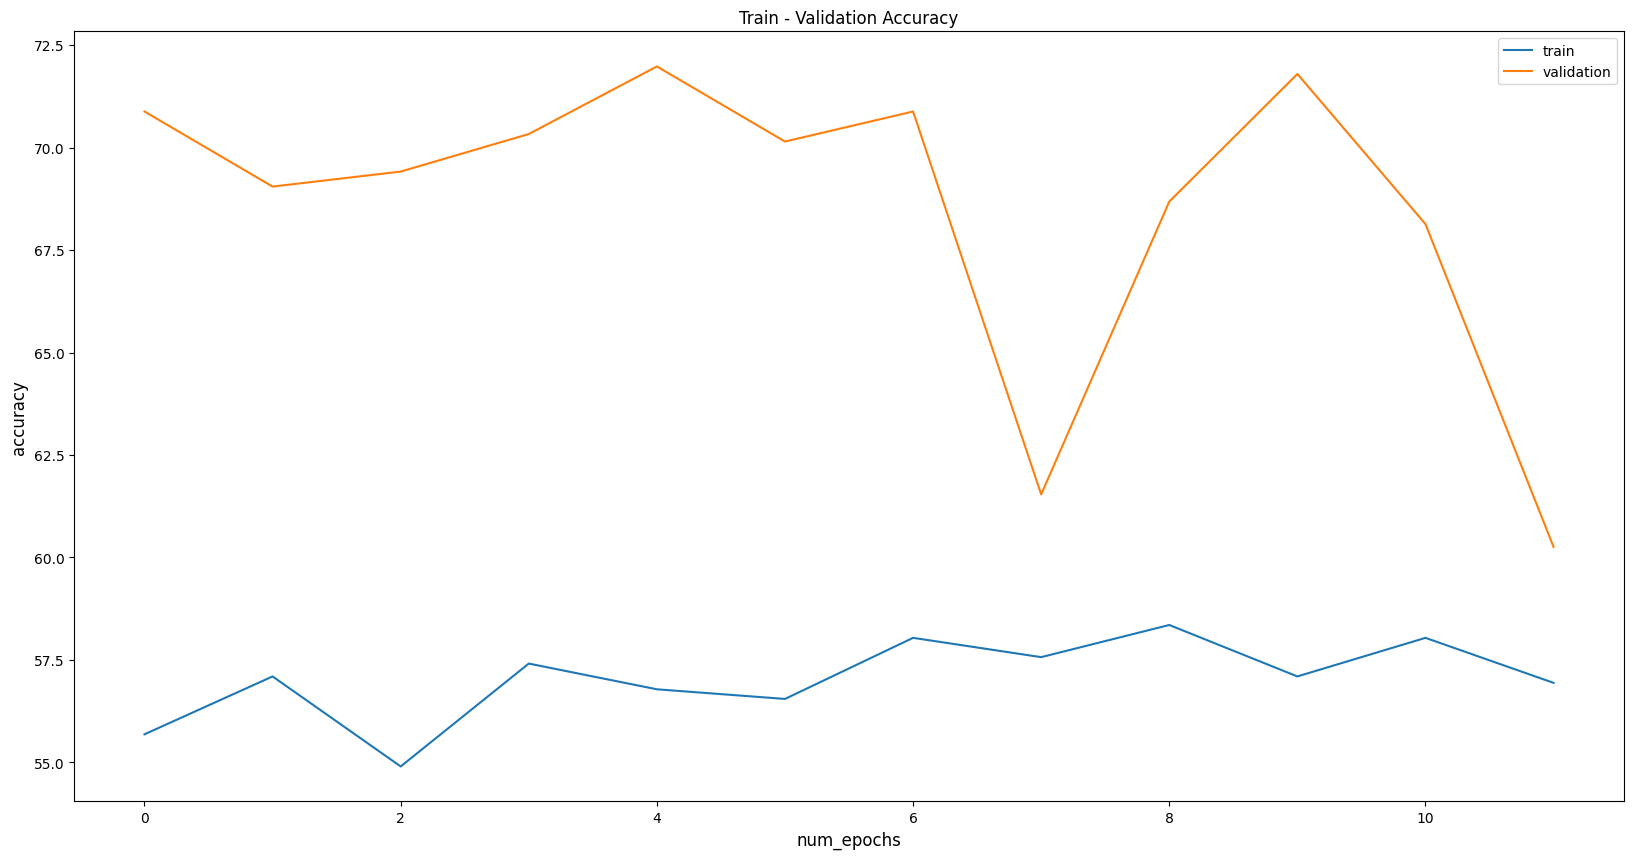

In [77]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from tqdm import tqdm, trange


PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "C:/Users/Manel/Desktop/Practica2/git/CustomViT/plant-pathology-2020-fgvc7/images"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060 SUPER'

In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [9]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.8136 Acc: 0.7133
val Loss: 0.5252 Acc: 0.7208

Epoch 1/49
----------
train Loss: 0.7089 Acc: 0.7416
val Loss: 0.4785 Acc: 0.7153

Epoch 2/49
----------
train Loss: 0.6448 Acc: 0.7612
val Loss: 0.4295 Acc: 0.7865

Epoch 3/49
----------
train Loss: 0.6105 Acc: 0.7973
val Loss: 0.4061 Acc: 0.8431

Epoch 4/49
----------
train Loss: 0.5901 Acc: 0.8068
val Loss: 0.3799 Acc: 0.8339

Epoch 5/49
----------
train Loss: 0.5747 Acc: 0.7973
val Loss: 0.3673 Acc: 0.8686

Epoch 6/49
----------
train Loss: 0.5607 Acc: 0.8052
val Loss: 0.3590 Acc: 0.8613

Epoch 7/49
----------
train Loss: 0.5306 Acc: 0.8248
val Loss: 0.3488 Acc: 0.8723

Epoch 8/49
----------
train Loss: 0.5284 Acc: 0.8280
val Loss: 0.3404 Acc: 0.8704

Epoch 9/49
----------
train Loss: 0.5294 Acc: 0.8209
val Loss: 0.3371 Acc: 0.8777

Epoch 10/49
----------
train Loss: 0.5103 Acc: 0.8374
val Loss: 0.3329 Acc: 0.8631

Epoch 11/49
----------
train Loss: 0.5180 Acc: 0.8233
val Loss: 0.3345 Acc: 0.8449

Ep

C:\Users\Manel\miniconda3\envs\customvit\lib\site-packages\torchvision\models\inception.py:44: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 0/49
----------
train Loss: 0.8895 Acc: 0.7062
val Loss: 0.6893 Acc: 0.7117

Epoch 1/49
----------
train Loss: 0.8276 Acc: 0.7164
val Loss: 0.5606 Acc: 0.7299

Epoch 2/49
----------
train Loss: 0.8208 Acc: 0.7203
val Loss: 0.5740 Acc: 0.7153

Epoch 3/49
----------
train Loss: 0.8248 Acc: 0.7031
val Loss: 0.5665 Acc: 0.7172

Epoch 4/49
----------
train Loss: 0.8243 Acc: 0.7188
val Loss: 0.5520 Acc: 0.7336

Epoch 5/49
----------
train Loss: 0.8143 Acc: 0.7148
val Loss: 0.5445 Acc: 0.7299

Epoch 6/49
----------
train Loss: 0.8071 Acc: 0.7133
val Loss: 0.5768 Acc: 0.7117

Epoch 7/49
----------
train Loss: 0.8265 Acc: 0.7078
val Loss: 0.5552 Acc: 0.7263

Epoch 8/49
----------
train Loss: 0.8074 Acc: 0.7086
val Loss: 0.5482 Acc: 0.7208

Epoch 9/49
----------
train Loss: 0.8057 Acc: 0.7038
val Loss: 0.5472 Acc: 0.7281

Epoch 10/49
----------
train Loss: 0.8169 Acc: 0.7117
val Loss: 0.5693 Acc: 0.7190

Epoch 11/49
----------
train Loss: 0.8074 Acc: 0.7141
val Loss: 0.5661 Acc: 0.7245

Ep

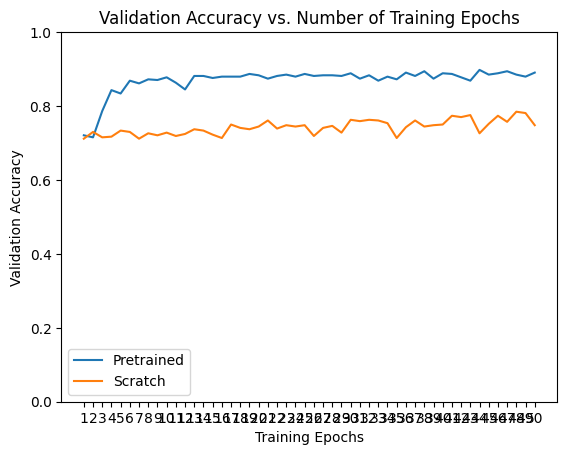

In [10]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Epoch 1 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:23<00:00,  2.47it/s]
                                                                                                                       

Epoch 1/50 loss: 0.51



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]


Test loss: 0.47
Test accuracy: 78.47%
Model Saved!


Epoch 2 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:22<00:00,  2.85it/s]
                                                                                                                       

Epoch 2/50 loss: 0.47



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.69it/s]


Test loss: 0.43
Test accuracy: 78.28%
Model Saved!


Epoch 3 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:22<00:00,  2.80it/s]
                                                                                                                       

Epoch 3/50 loss: 0.43



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.58it/s]


Test loss: 0.40
Test accuracy: 87.41%
Model Saved!


Epoch 4 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  3.48it/s]
                                                                                                                       

Epoch 4/50 loss: 0.41



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.66it/s]


Test loss: 0.36
Test accuracy: 85.40%
Model Saved!


Epoch 5 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:22<00:00,  2.87it/s]
                                                                                                                       

Epoch 5/50 loss: 0.39



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]


Test loss: 0.35
Test accuracy: 86.68%
Model Saved!


Epoch 6 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:22<00:00,  2.93it/s]
                                                                                                                       

Epoch 6/50 loss: 0.38



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.68it/s]


Test loss: 0.34
Test accuracy: 85.77%
Model Saved!


Epoch 7 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:22<00:00,  2.94it/s]
                                                                                                                       

Epoch 7/50 loss: 0.37



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.66it/s]


Test loss: 0.33
Test accuracy: 86.13%
Model Saved!


Epoch 8 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:22<00:00,  2.75it/s]
                                                                                                                       

Epoch 8/50 loss: 0.36



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]


Test loss: 0.32
Test accuracy: 87.96%
Model Saved!


Epoch 9 in training:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [00:23<00:00,  2.88it/s]
                                                                                                                       

Epoch 9/50 loss: 0.36



Training:  18%|█████████████▏                                                           | 9/50 [05:09<23:33, 34.47s/it]

Test loss: 0.34
Test accuracy: 88.32%



Epoch 10 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.86it/s]
                                                                                                                       

Epoch 10/50 loss: 0.34



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.64it/s]


Test loss: 0.31
Test accuracy: 86.50%
Model Saved!


Epoch 11 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:28<00:00,  2.89it/s]
                                                                                                                       

Epoch 11/50 loss: 0.34



Training:  22%|███████████████▊                                                        | 11/50 [06:24<23:32, 36.22s/it]

Test loss: 0.33
Test accuracy: 88.32%



Epoch 12 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.67it/s]
                                                                                                                       

Epoch 12/50 loss: 0.32



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.63it/s]


Test loss: 0.30
Test accuracy: 88.50%
Model Saved!


Epoch 13 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  3.47it/s]
                                                                                                                       

Epoch 13/50 loss: 0.33



Training:  26%|██████████████████▋                                                     | 13/50 [07:35<22:06, 35.84s/it]

Test loss: 0.32
Test accuracy: 88.50%



Epoch 14 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.85it/s]
                                                                                                                       

Epoch 14/50 loss: 0.32



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.63it/s]


Test loss: 0.29
Test accuracy: 88.87%
Model Saved!


Epoch 15 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.88it/s]
                                                                                                                       

Epoch 15/50 loss: 0.31



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]


Test loss: 0.28
Test accuracy: 88.87%
Model Saved!


Epoch 16 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  3.46it/s]
                                                                                                                       

Epoch 16/50 loss: 0.31



Training:  32%|███████████████████████                                                 | 16/50 [09:21<20:03, 35.39s/it]

Test loss: 0.29
Test accuracy: 89.05%



Epoch 17 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.89it/s]
                                                                                                                       

Epoch 17/50 loss: 0.32



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.61it/s]


Test loss: 0.28
Test accuracy: 88.87%
Model Saved!


Epoch 18 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.66it/s]
                                                                                                                       

Epoch 18/50 loss: 0.32



Training:  36%|█████████████████████████▉                                              | 18/50 [10:32<19:01, 35.66s/it]

Test loss: 0.30
Test accuracy: 87.77%



Epoch 19 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:27<00:00,  2.81it/s]
                                                                                                                       

Epoch 19/50 loss: 0.30



Training:  38%|███████████████████████████▎                                            | 19/50 [11:11<18:57, 36.70s/it]

Test loss: 0.30
Test accuracy: 87.96%



Epoch 20 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  3.35it/s]
                                                                                                                       

Epoch 20/50 loss: 0.31



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]


Test loss: 0.27
Test accuracy: 87.96%
Model Saved!


Epoch 21 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:31<00:00,  2.79it/s]
                                                                                                                       

Epoch 21/50 loss: 0.29



Training:  42%|██████████████████████████████▏                                         | 21/50 [12:30<18:33, 38.40s/it]

Test loss: 0.29
Test accuracy: 89.78%



Epoch 22 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.78it/s]
                                                                                                                       

Epoch 22/50 loss: 0.31



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.61it/s]


Test loss: 0.27
Test accuracy: 89.42%
Model Saved!


Epoch 23 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.85it/s]
                                                                                                                       

Epoch 23/50 loss: 0.30



Training:  46%|█████████████████████████████████                                       | 23/50 [13:42<16:41, 37.08s/it]

Test loss: 0.30
Test accuracy: 89.05%



Epoch 24 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.71it/s]
                                                                                                                       

Epoch 24/50 loss: 0.30



Training:  48%|██████████████████████████████████▌                                     | 24/50 [14:18<15:55, 36.76s/it]

Test loss: 0.27
Test accuracy: 89.78%



Epoch 25 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.54it/s]
                                                                                                                       

Epoch 25/50 loss: 0.29



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51it/s]


Test loss: 0.26
Test accuracy: 88.87%
Model Saved!


Epoch 26 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.82it/s]
                                                                                                                       

Epoch 26/50 loss: 0.29



Training:  52%|█████████████████████████████████████▍                                  | 26/50 [15:31<14:39, 36.66s/it]

Test loss: 0.28
Test accuracy: 88.87%



Epoch 27 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:30<00:00,  2.71it/s]
                                                                                                                       

Epoch 27/50 loss: 0.29



Training:  54%|██████████████████████████████████████▉                                 | 27/50 [16:13<14:41, 38.34s/it]

Test loss: 0.29
Test accuracy: 89.60%



Epoch 28 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:25<00:00,  2.76it/s]
                                                                                                                       

Epoch 28/50 loss: 0.30



Training:  56%|████████████████████████████████████████▎                               | 28/50 [16:50<13:54, 37.91s/it]

Test loss: 0.27
Test accuracy: 89.96%



Epoch 29 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.81it/s]
                                                                                                                       

Epoch 29/50 loss: 0.30



Training:  58%|█████████████████████████████████████████▊                              | 29/50 [17:25<12:58, 37.06s/it]

Test loss: 0.27
Test accuracy: 89.78%



Epoch 30 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.79it/s]
                                                                                                                       

Epoch 30/50 loss: 0.29



Training:  60%|███████████████████████████████████████████▏                            | 30/50 [18:01<12:12, 36.62s/it]

Test loss: 0.27
Test accuracy: 90.15%



Epoch 31 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.74it/s]
                                                                                                                       

Epoch 31/50 loss: 0.29



Training:  62%|████████████████████████████████████████████▋                           | 31/50 [18:38<11:36, 36.64s/it]

Test loss: 0.26
Test accuracy: 89.96%



Epoch 32 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.62it/s]
                                                                                                                       

Epoch 32/50 loss: 0.27



Training:  64%|██████████████████████████████████████████████                          | 32/50 [19:15<11:03, 36.84s/it]

Test loss: 0.28
Test accuracy: 89.23%



Epoch 33 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  3.30it/s]
                                                                                                                       

Epoch 33/50 loss: 0.28



Training:  66%|███████████████████████████████████████████████▌                        | 33/50 [19:51<10:21, 36.55s/it]

Test loss: 0.29
Test accuracy: 86.50%



Epoch 34 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  3.46it/s]
                                                                                                                       

Epoch 34/50 loss: 0.29



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]


Test loss: 0.26
Test accuracy: 90.69%
Model Saved!


Epoch 35 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  3.37it/s]
                                                                                                                       

Epoch 35/50 loss: 0.28



Training:  70%|██████████████████████████████████████████████████▍                     | 35/50 [21:10<09:29, 37.95s/it]

Test loss: 0.27
Test accuracy: 89.23%



Epoch 36 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:25<00:00,  2.73it/s]
                                                                                                                       

Epoch 36/50 loss: 0.27



Training:  72%|███████████████████████████████████████████████████▊                    | 36/50 [21:47<08:47, 37.71s/it]

Test loss: 0.28
Test accuracy: 89.60%



Epoch 37 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.75it/s]
                                                                                                                       

Epoch 37/50 loss: 0.27



Training:  74%|█████████████████████████████████████████████████████▎                  | 37/50 [22:23<08:03, 37.22s/it]

Test loss: 0.27
Test accuracy: 89.23%



Epoch 38 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:25<00:00,  2.77it/s]
                                                                                                                       

Epoch 38/50 loss: 0.29



Training:  76%|██████████████████████████████████████████████████████▋                 | 38/50 [23:00<07:24, 37.02s/it]

Test loss: 0.26
Test accuracy: 90.88%



Epoch 39 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.82it/s]
                                                                                                                       

Epoch 39/50 loss: 0.29



Training:  78%|████████████████████████████████████████████████████████▏               | 39/50 [23:35<06:41, 36.52s/it]

Test loss: 0.27
Test accuracy: 89.42%



Epoch 40 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.82it/s]
                                                                                                                       

Epoch 40/50 loss: 0.29



Training:  80%|█████████████████████████████████████████████████████████▌              | 40/50 [24:11<06:01, 36.15s/it]

Test loss: 0.26
Test accuracy: 90.33%



Epoch 41 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:23<00:00,  2.84it/s]
                                                                                                                       

Epoch 41/50 loss: 0.28



Training:  82%|███████████████████████████████████████████████████████████             | 41/50 [24:46<05:22, 35.83s/it]

Test loss: 0.27
Test accuracy: 88.87%



Epoch 42 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:31<00:00,  2.80it/s]
                                                                                                                       

Epoch 42/50 loss: 0.27



Training:  84%|████████████████████████████████████████████████████████████▍           | 42/50 [25:29<05:03, 37.94s/it]

Test loss: 0.27
Test accuracy: 90.33%



Epoch 43 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:24<00:00,  2.59it/s]
                                                                                                                       

Epoch 43/50 loss: 0.28



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.61it/s]


Test loss: 0.26
Test accuracy: 90.33%
Model Saved!


Epoch 44 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  3.42it/s]
                                                                                                                       

Epoch 44/50 loss: 0.28



Training:  88%|███████████████████████████████████████████████████████████████▎        | 44/50 [26:40<03:39, 36.65s/it]

Test loss: 0.26
Test accuracy: 90.88%



Epoch 45 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:32<00:00,  2.67it/s]
                                                                                                                       

Epoch 45/50 loss: 0.27



Training:  90%|████████████████████████████████████████████████████████████████▊       | 45/50 [27:24<03:15, 39.03s/it]

Test loss: 0.26
Test accuracy: 89.96%



Epoch 46 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:29<00:00,  2.76it/s]
                                                                                                                       

Epoch 46/50 loss: 0.27



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.63it/s]


Test loss: 0.25
Test accuracy: 90.51%
Model Saved!


Epoch 47 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:25<00:00,  2.73it/s]
                                                                                                                       

Epoch 47/50 loss: 0.27



Training:  94%|███████████████████████████████████████████████████████████████████▋    | 47/50 [28:42<01:56, 38.77s/it]

Test loss: 0.25
Test accuracy: 90.33%



Epoch 48 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  3.34it/s]
                                                                                                                       

Epoch 48/50 loss: 0.28



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]


Test loss: 0.25
Test accuracy: 90.51%
Model Saved!


Epoch 49 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:28<00:00,  2.69it/s]
                                                                                                                       

Epoch 49/50 loss: 0.27



Training:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [30:01<00:39, 39.16s/it]

Test loss: 0.29
Test accuracy: 89.42%



Epoch 50 in training:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [00:25<00:00,  2.66it/s]
                                                                                                                       

Epoch 50/50 loss: 0.29



Training: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [30:38<00:00, 36.77s/it]

Test loss: 0.28
Test accuracy: 89.23%


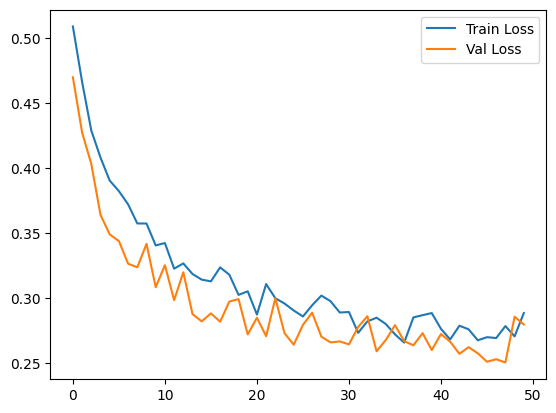

In [44]:
MODEL_PATH= "models/inceptionV3plants.pth"

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
bestLoss = 999999;

train_losses = []
val_losses = []
for epoch in trange(num_epochs, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(dataloaders_dict['train'], desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model_ft(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(dataloaders_dict['train'])

        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(dataloaders_dict['val'], desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model_ft(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(dataloaders_dict['val'])

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
        val_losses.append(test_loss)
        if test_loss < bestLoss:
            print("Model Saved!")
            torch.save(model_ft.state_dict(), MODEL_PATH)
            bestLoss = test_loss


# %%
fig, ax = plt.subplots()

ax.plot(np.arange(num_epochs), train_losses)
ax.plot(np.arange(num_epochs), val_losses)
ax.legend(['Train Loss', 'Val Loss'])